<h1> Predicting Shot Types with a ResNet-50 </h1>

<h2> Table of Contents </h2>

1. [Downloading the Model & Data](#download)
2. [Setting Up the Model](#model)
3. [Reproducing the Confusion Matrix](#conf-mt)
4. [Predicting New Images](#predict)

<br>


In [ ]:
%matplotlib inline

from fastai.vision import *
from pathlib import Path

Change the `path` to where this directory exists on your system

In [ ]:
path = Path('/Users/rahulsomani/01_github_projects/shot-type-classifier/')

## Downloading the Model & Data <a id='download'>

Run this section if you haven't run `get_data_model.sh` yet

In [ ]:
%%bash -s $path
mkdir $1/models
wget -O $1/models/shot-type-classifier.pth 'https://www.dropbox.com/s/f9703kbb2l82fsd/stage-3-2.pth?dl=0'

In [ ]:
%%bash -s $path
wget --max-redirect=20 -O $1/train.zip 'https://www.dropbox.com/sh/c164dthxczdqwmd/AADJIKAYXp1wPkMFznQlZ1Cka?dl=0'

mkdir $1/train
mv $1/train.zip $1/train
cd $1/train
unzip train.zip
rm train.zip

In [ ]:
%%bash -s $path
wget --max-redirect=20 -O $1/valid.zip 'https://www.dropbox.com/sh/d8rrrwg7zihzz7y/AAAnFE5jSEroVA0Q5u9ugecQa?dl=0'

cd $1
mkdir $1/valid
mv $1/valid.zip $1/valid
cd $1/valid
unzip valid.zip
rm valid.zip

---

## Setting Up the Model <a id='model'>

In [ ]:
def xtra_tfms(base_size = 75*5): 
    box_dim = int(base_size/4)
    cutout_ = partial(cutout, p = .8, n_holes = (1,1), length = (box_dim, box_dim))
    jitter_ = partial(jitter, p = 0.5,  magnitude = (0.005, 0.01))
    skew_   = partial(skew,   p = 0.5, direction = (0, 7), magnitude = 0.2)
    squish_ = partial(squish, p = 0.5, row_pct = 0.25, col_pct = 0.25)
    tilt_   = partial(tilt,   p = 0.5, direction = (0, 3))
    perp_warp_ = partial(perspective_warp, p = 0.5, magnitude = (-0.2, 0.2))
    crop_pad_  = partial(crop_pad, p = 0.5, padding_mode = 'border', row_pct = 0.1, col_pct = 0.1)
    rgb_randomize_ = partial(rgb_randomize, thresh=0.05)
    
    xtra_tfms = [jitter_(), skew_(), squish_(), perp_warp_(),
                 tilt_(), cutout_(), crop_pad_()]
    
    return xtra_tfms

In [ ]:
def get_tfms(): return get_transforms(do_flip = True,
                                      flip_vert = False,
                                      max_zoom = 1.,
                                      max_lighting = 0.4,
                                      max_warp = 0.3,
                                      p_affine = 0.85,
                                      p_lighting = 0.85,
                                      xtra_tfms = xtra_tfms())

In [ ]:
data = ImageDataBunch.from_folder(path, 'train', 'valid', size = (375, 666), ds_tfms = get_tfms(), bs=1,
                                  resize_method = ResizeMethod.SQUISH,
                                  num_workers = 0
                                 ).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy], pretrained=True)
learn = learn.to_fp16()

In [ ]:
learn.load(path/'models'/'shot-type-classifier');

---

## Reproducing the Confusion Matrix <a id='conf-mt'>

This confusion matrix is *slightly* different than the one I'd produced in the methodology notebook. <br>
I think this is due to some minor change in the data augmentations applied.

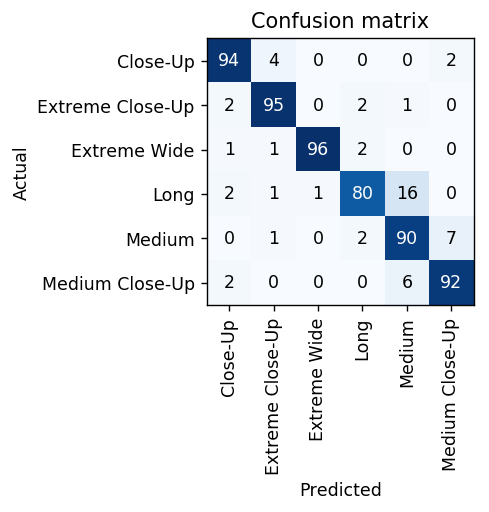

In [ ]:
# this could take a while (~12 mins on a 2015 MacBook Pro Retina) if you don't have a GPU

learn = learn.to_fp32()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 125)

---

## Predicting New Images <a id='predict'>

Replace the `path_img` with any folder that has all the images you want to analyse.<br>
Here, I just pick the `Close-Up` folder from the validation set

In [ ]:
!tree -d {path}

/Users/rahulsomani/01_github_projects/shot-type-classifier
├── models
├── train
│   ├── Close-Up
│   ├── Extreme\ Close-Up
│   ├── Extreme\ Wide
│   ├── Long
│   ├── Medium
│   └── Medium\ Close-Up
├── valid
│   ├── Close-Up
│   ├── Extreme\ Close-Up
│   ├── Extreme\ Wide
│   ├── Long
│   ├── Medium
│   └── Medium\ Close-Up
└── valid_preds

16 directories


In [ ]:
learn = learn.to_fp32()

path_img = path/'valid'/'Close-Up'
tests = [f for f in os.listdir(path_img) if f.endswith(('.jpg', '.jpeg', '.png'))]

### Predict Image & View

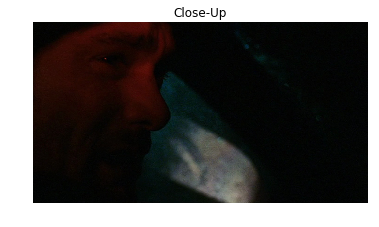

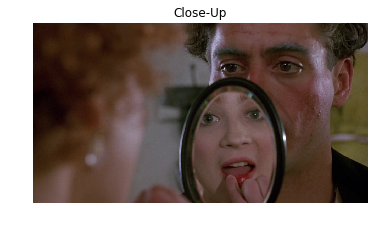

In [ ]:
os.chdir(path_img)
for file in tests[:2]:
    img = open_image(file)
    img.show(figsize = (6, 8), title = str(learn.predict(img)[0]))

### Predict Image + Probabilities

,shot-type,prediction
0,EWS,0.000017
1,LS,0.000083
2,MS,0.000020
3,MCU,0.000584
4,CU,99.996138
5,ECU,0.003164


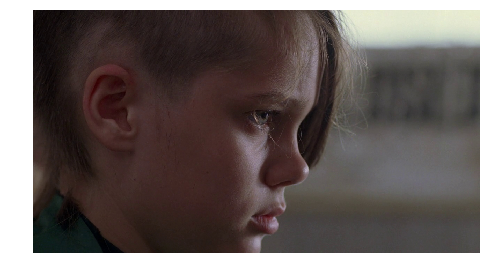

In [ ]:
os.chdir(path_img)
x = open_image(tests[5])

# get preds
preds_num = learn.predict(x)[2].numpy()

# form data-frame
df = pd.DataFrame(list(zip(data.classes, preds_num )), columns=['shot-type', 'prediction'])

# order from largest to smallest shot size
df['shot-type'].replace({'Extreme Wide': 'EWS',
                         'Long': 'LS',
                         'Medium': 'MS',
                         'Medium Close-Up': 'MCU',
                         'Close-Up': 'CU',
                         'Extreme Close-Up': 'ECU'}, inplace=True)
df['shot-type'] = pd.Categorical(df['shot-type'], ['EWS', 'LS', 'MS', 'MCU', 'CU', 'ECU'])
df['prediction'] *= 100
df = df.sort_values('shot-type').reset_index(drop=True)

# display
x.show(figsize=(8, 10))
df

### Saving Probabilities to Disk

In [ ]:
# `path`      --> directory where the image files you want to predict exist
# `path_save` --> (optional) directory where you want to save the predictions.
#                 creates it if it doesn't exist. 
                 

def save_preds(path, path_save=None):
    print(path_save)
    os.mkdir(path_save) if not os.path.exists(path_save) else None
    
    os.chdir(path)
    files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    for file in files:
        # open file
        x = open_image(file)

        # get preds
        preds_num = learn.predict(x)[2].numpy()

        # form data-frame
        df = pd.DataFrame(list(zip(data.classes, preds_num )), columns=['shot-type', 'prediction'])

        # reorder data-frame from largest to smallest shot size
        df['shot-type'].replace({    'Extreme Wide': 'EWS',
                                             'Long': 'LS',
                                           'Medium': 'MS',
                                  'Medium Close-Up': 'MCU',
                                         'Close-Up': 'CU',
                                 'Extreme Close-Up': 'ECU'}, inplace=True)
        df['shot-type'] = pd.Categorical(df['shot-type'], ['EWS', 'LS', 'MS', 'MCU', 'CU', 'ECU'])
        df = df.sort_values('shot-type').reset_index(drop=True)

        # probability --> percentage
        df['prediction'] *= 100

        
        # save to disk
        fname = file.rpartition('.')[0] + '_preds.csv'
        if path_save is not None:
            df.to_csv(Path(path_save)/fname, index=False)

        else:
            df.to_csv(Path(path)/fname, index=False)

In [ ]:
save_preds('/Users/rahulsomani/01_github_projects/shot-type-classifier/train/Close-Up/', 
           '/Users/rahulsomani/01_github_projects/shot-type-classifier/train/Close-Up/preds/')

## Heatmaps

### Setup

In [ ]:
from shutil import rmtree
from fastai.callbacks.hooks import *
from matplotlib.ticker import NullLocator

In [ ]:
learn = learn.to_fp32()
x,y = data.valid_ds[0]

In [ ]:
m = learn.model.eval();

In [ ]:
def hooked_backward(cat=y):
    # m[0] is the first part of the network i.e. NOT the FC layer
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
def show_heatmap(hm, path, only_heatmap=False, interpolation='bilinear', alpha=0.5):
    _,ax = plt.subplots(figsize=(5,3))
    
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    
    if not only_heatmap: xb_im.show(ax)
    ax.imshow(hm, alpha=alpha, extent=(0,666,375,0),
              interpolation=interpolation, cmap='YlOrRd');

### Generating the Heatmaps

In [ ]:
path_img = '/Users/rahulsomani/Desktop/img/'
alpha = 0.5

In [ ]:
path_img = Path(path_img)
path_hms = Path(path_hms)

In [ ]:
files = [f for f in os.listdir(path_img) if f.endswith(('.jpg', '.jpeg', '.png'))]

In [ ]:
os.mkdir(path_img/'train') if not os.path.exists(path_img/'train') else None
os.mkdir(path_img/'train'/'img') if not os.path.exists(path_img/'train'/'img') else None

# move from base dir to dummy train dir
[os.rename(path_img/file, path_img/'train'/'img'/file) for file in files];

In [ ]:
temp = ImageDataBunch.from_folder(path_img, 'train', size = (375, 666), ds_tfms = None, bs=1,
                                  resize_method = ResizeMethod.SQUISH, no_check=True,
                                  num_workers = 0
                                 ).normalize(imagenet_stats)

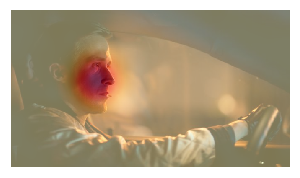

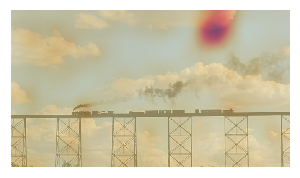

In [ ]:
for idx in range(len(temp.train_ds)):
    x,y = temp.train_ds[idx]
    path_valid = path_hms
    xb = temp.one_item(x)[0]    
    if torch.cuda.is_available(): xb = xb.cuda()
    xb_im = Image(temp.denorm(xb)[0])
    hook_a,hook_g = hooked_backward()
    acts  = hook_a.stored[0].cpu()
    avg_acts = acts.mean(0)
    
    show_heatmap(avg_acts, path_valid, only_heatmap=False, interpolation='spline16', alpha=alpha)

In [ ]:
# move from dummy train dir to base dir
[os.rename(path_img/'train'/'img'/file, path_img/file) for file in files];
rmtree(path_img/'train')